# Lab 5 Accuracy of Quantum Phase Estimation

Prerequisite
- [Ch.3.5 Quantum Fourier Transform](/course/ch-algorithms/quantum-fourier-transform)
- [Ch.3.6 Quantum Phase Estimation](/course/ch-algorithms/quantum-phase-estimation)

Other relevant materials
- [QCQI] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information

In [7]:
from qiskit import *
import numpy as np
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import *
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
import math
from qiskit.circuit.library import QFT

## Part 1: Performance of Quantum Phase Estimation


**Goal**

Investigate the relationship between the number of qubits required for the desired accuracy of the phase estimation with high probability.


The accuracy of the estimated value through Quantum Phase Estimation (QPE) and its probability of success depend on the number of qubits employed in QPE circuits. Therefore, one might want to know the necessary number of qubits to achieve the targeted level of QPE performance, especially when the phase that needs to be determined cannot be decomposed in a finite bit binary expansion. 
In Part 1 of this lab, we examine the number of qubits required to accomplish the desired accuracy and the probability of success in determining the phase through QPE.

### 1. Find the probability of obtaining the estimation for a phase value accurate to $2^{-2}$ successfully with four counting qubits.

#### &#128211;Step A. Set up the QPE circuit with four counting qubits and save the circuit to the variable 'qc4'.  Execute 'qc4' on a qasm simulator.  Plot the histogram of the result.

Check the QPE chapter in Qiskit textbook ( go to `3. Example: Getting More Precision` section [here](/course/ch-algorithms/quantum-phase-estimation) ) for the circuit.

In [8]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(n)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [4]:
a=qft(4)
a.draw()

┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

In [9]:
# Create and set up circuit
qpe2 = QuantumCircuit(5, 4)

# Apply H-Gates to counting qubits:
for qubit in range(4):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(4)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(4):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 4);
    repetitions *= 2

# Do the inverse QFT:
qpe2 = qpe2.compose(QFT(4, inverse=True), [0,1,2,3])

# Measure of course!
for n in range(4):
    qpe2.measure(n,n)

qpe2.draw()


┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_4: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c_0: ═════════════════════════════════════════════════════════════════»
                                                                      »
c_1: ═════════════════════════════════════════════════════════════════»
                                                                      »
c_2: ═════════════════════════════════════════════════════════════════»
                                                                      »
c_3: ═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_4: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c_0: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_1: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_2: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_3: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                         ┌──────────┐┌─┐         
«q_0: ────────────────────┤0         ├┤M├─────────
«                         │          │└╥┘┌─┐      
«q_1: ────────────────────┤1         ├─╫─┤M├──────
«                         │  IQFT_dg │ ║ └╥┘┌─┐   
«q_2: ────────────────────┤2         ├─╫──╫─┤M├───
«                         │          │ ║  ║ └╥┘┌─┐
«q_3: ─■─────────■────────┤3         ├─╫──╫──╫─┤M├
«      │P(2π/3)  │P(2π/3) └──────────┘ ║  ║  ║ └╥┘
«q_4: ─■─────────■─────────────────────╫──╫──╫──╫─
«                                      ║  ║  ║  ║ 
«c_0: ═════════════════════════════════╩══╬══╬══╬═
«                                         ║  ║  ║ 
«c_1: ════════════════════════════════════╩══╬══╬═
«                                            ║  ║ 
«c_2: ═══════════════════════════════════════╩══╬═
«                                               ║ 
«c_3: ══════════════════════════════════════════╩═
«

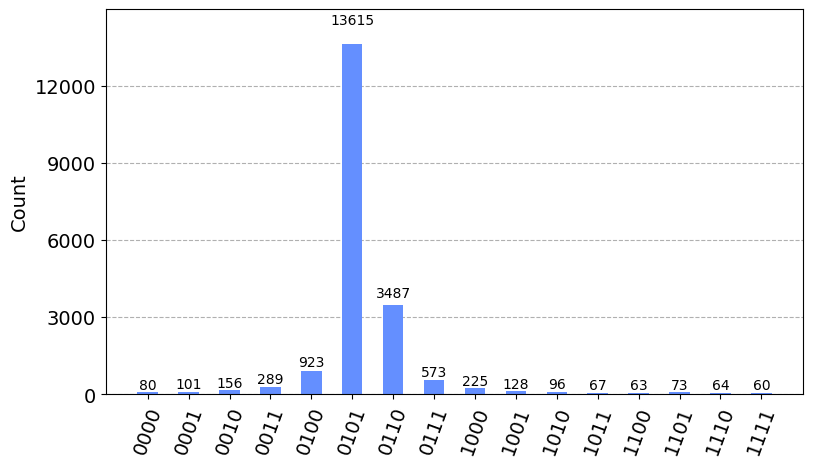

In [10]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
sim = Aer.get_backend('qasm_simulator')
shots = 20000
count_qc4 = execute(qpe2, sim, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

Having performed `Step A` successfully, you will have obtained a distribution similar to the one shown below with the highest probability at `0101` which corresponds to the estimated $\phi$ value, `0.3125`.

![](images/L5_qc4_hist.png)

Since the number of counting qubits used for the circuit is four, the best estimated value should be accurate to $\delta = 2^{-4} = 0.0625$.  However, there are multiple possible outcomes as $\theta = 1/3$ cannot be expressed in a finite number of bits, the estimation by QPE here is not always bounded by this accuracy. 

Running the following cell shows the same histogram but with all possible estimated $\phi$ values on the x-axis.

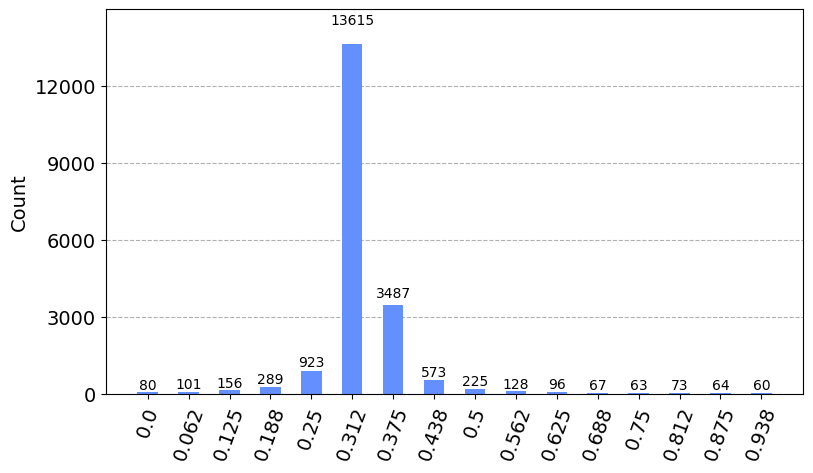

In [11]:
t=4
phi_est = np.array([round(int(key, 2)/2**t,3) for key in list(count_qc4.keys())])
key_new = list(map(str, phi_est))
count_new = dict(zip(key_new, count_qc4.values()))
plot_histogram(count_new, figsize=(9,5))

**Suppose the outcome of the final measurement is $m$, and let $b$ the best estimation which is `0.3125` for this case.**
#### &#128211;Step B. Find $e$, the maximum difference in integer from the best estimation <code>0101</code> so that all the outcomes, 'm's, would approximate $\phi$ to an accuracy $2^{-2}$ when $|m - b| \leq \frac{e}{2^{t}}$. 

In this case, the values of $t$ and $b$ are $4$ and $0.3125$, respectively.

For example, under $e = 1$, the considered outcomes are `0100`, `0101`, `0110` which correspond to the values of $m$: $0.25,~0.312,~0.375$, respectively, and all of them approximate the value $\frac{1}{3}$ to an accuracy $2^{-2}$.

In [12]:
## Your code goes here
b=0.3125
Int_b=2**t*b
m=0.312
d=0.25
Upper=2**t*(b+d)
difference=Upper-Int_b
print("Integer Difference=",difference)







Integer Difference= 4.0


#### &#128211;Step C. Compute the probability of obtaining an approximation correct to an accuracy $2^{-2}$.  Verify that the computed probability value is larger or equal to $1- \frac{1}{2(2^{(t-n)}-2)}$ where $t$ is the number of counting bits and the $2^{-n}$ is the desired accuracy. 

Now it is easy to evaluate the probability of the success from the histogram since all the outcomes that approximate $\phi$ to the accuracy $2^{-2}$ can be found based on the maximum difference $e$ from the best estimate. 

In [15]:
## Your code goes here
## finding accuracy needed in terms of phi
t=4
n=2
Upper_phi=Upper/(2**t)
print(Upper_phi)
Lower_phi=b-(Upper_phi-b)
print(Lower_phi)
good_outputs=0
for key in count_new:
    if float(key) < Upper_phi and float(key) > Lower_phi:
        good_outputs+= count_new[key]

p=1-1/(2*(2**(t-n)-2))
good_p=good_outputs/20000
print("Prooprtion of good outputs",good_p,"> Threshold Probability",p)







0.5625
0.0625
Prooprtion of good outputs 0.9698 > Threshold Probability 0.75


### 2. Compute the probability of success for the accuracy $2^{-2}$ when the number of counting qubits, $t$, varies from four to nine. Compare your result with the equation $t=n+log(2+\frac{1}{2\epsilon})$ when $2^{-n}$ is the desired accuracy and $\epsilon$ is 1 - probability  of success. 

The following plot shows the relationship between the number of counting qubit, t, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$.  Check the Ch. 5.2.1 Performance and requirements in `[QCQI]`.

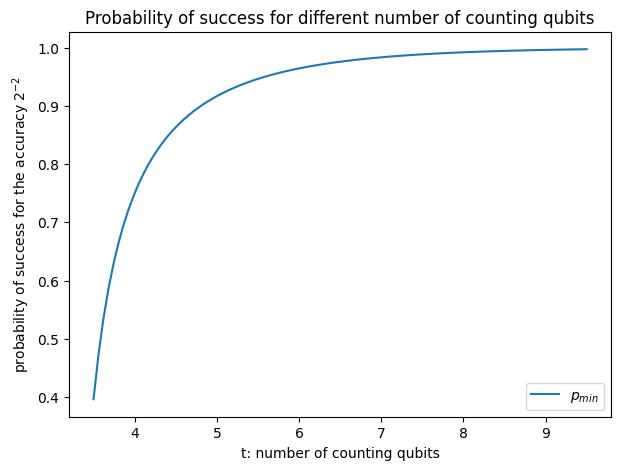

In [16]:
y = lambda t, n: 1-1/(2*(2**(t-n)-2))
t_q = np.linspace(3.5, 9.5, 100 )
p_min = y(t_q, 2)

plt.figure(figsize=(7, 5))
plt.plot(t_q, p_min, label='$p_{min}$')
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-2}$')
plt.legend(loc='lower right')
plt.title('Probability of success for different number of counting qubits')
plt.show()

#### &#128211;Step A. Construct QPE circuit to estimate $\phi$ when $\phi = 1/3$ with for the different number of counting qubits, $t$, when $t = [4, 5, 6, 7, 8, 9]$. Store all the circuits in a list variable 'circ' to simulate all the circuits at once as we did in Lab3. 

In [33]:
## Your Code to create the list variable 'circ' goes here

def circ1(t):
    # Create and set up circuit
    qpe2 = QuantumCircuit(t+1, t)

# Apply H-Gates to counting qubits:
    for qubit in range(t):
        qpe2.h(qubit)

# Prepare our eigenstate |psi>:
    qpe2.x(t)

# Do the controlled-U operations:
    angle = 2*math.pi/3
    repetitions = 1
    for counting_qubit in range(t):
        for i in range(repetitions):
            qpe2.cp(angle, counting_qubit, t);
        repetitions *= 2

# Do the inverse QFT:
    xs = range(t)
    qpe2 = qpe2.compose(QFT(t, inverse=True), xs)

# Measure of course!
    for n in range(t):
        qpe2.measure(n,n)
    return(qpe2)

a = np.array([4, 5, 6, 7, 8, 9])
circ=[]
for i in range(len(a)):
    circ.append(circ1(a[i]))


┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_4: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c_0: ═════════════════════════════════════════════════════════════════»
                                                                      »
c_1: ═════════════════════════════════════════════════════════════════»
                                                                      »
c_2: ═════════════════════════════════════════════════════════════════»
                                                                      »
c_3: ═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_4: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c_0: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_1: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_2: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«c_3: ══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                         ┌──────────┐┌─┐         
«q_0: ────────────────────┤0         ├┤M├─────────
«                         │          │└╥┘┌─┐      
«q_1: ────────────────────┤1         ├─╫─┤M├──────
«                         │  IQFT_dg │ ║ └╥┘┌─┐   
«q_2: ────────────────────┤2         ├─╫──╫─┤M├───
«                         │          │ ║  ║ └╥┘┌─┐
«q_3: ─■─────────■────────┤3         ├─╫──╫──╫─┤M├
«      │P(2π/3)  │P(2π/3) └──────────┘ ║  ║  ║ └╥┘
«q_4: ─■─────────■─────────────────────╫──╫──╫──╫─
«                                      ║  ║  ║  ║ 
«c_0: ═════════════════════════════════╩══╬══╬══╬═
«                                         ║  ║  ║ 
«c_1: ════════════════════════════════════╩══╬══╬═
«                                            ║  ║ 
«c_2: ═══════════════════════════════════════╩══╬═
«                                               ║ 
«c_3: ══════════════════════════════════════════╩═
«

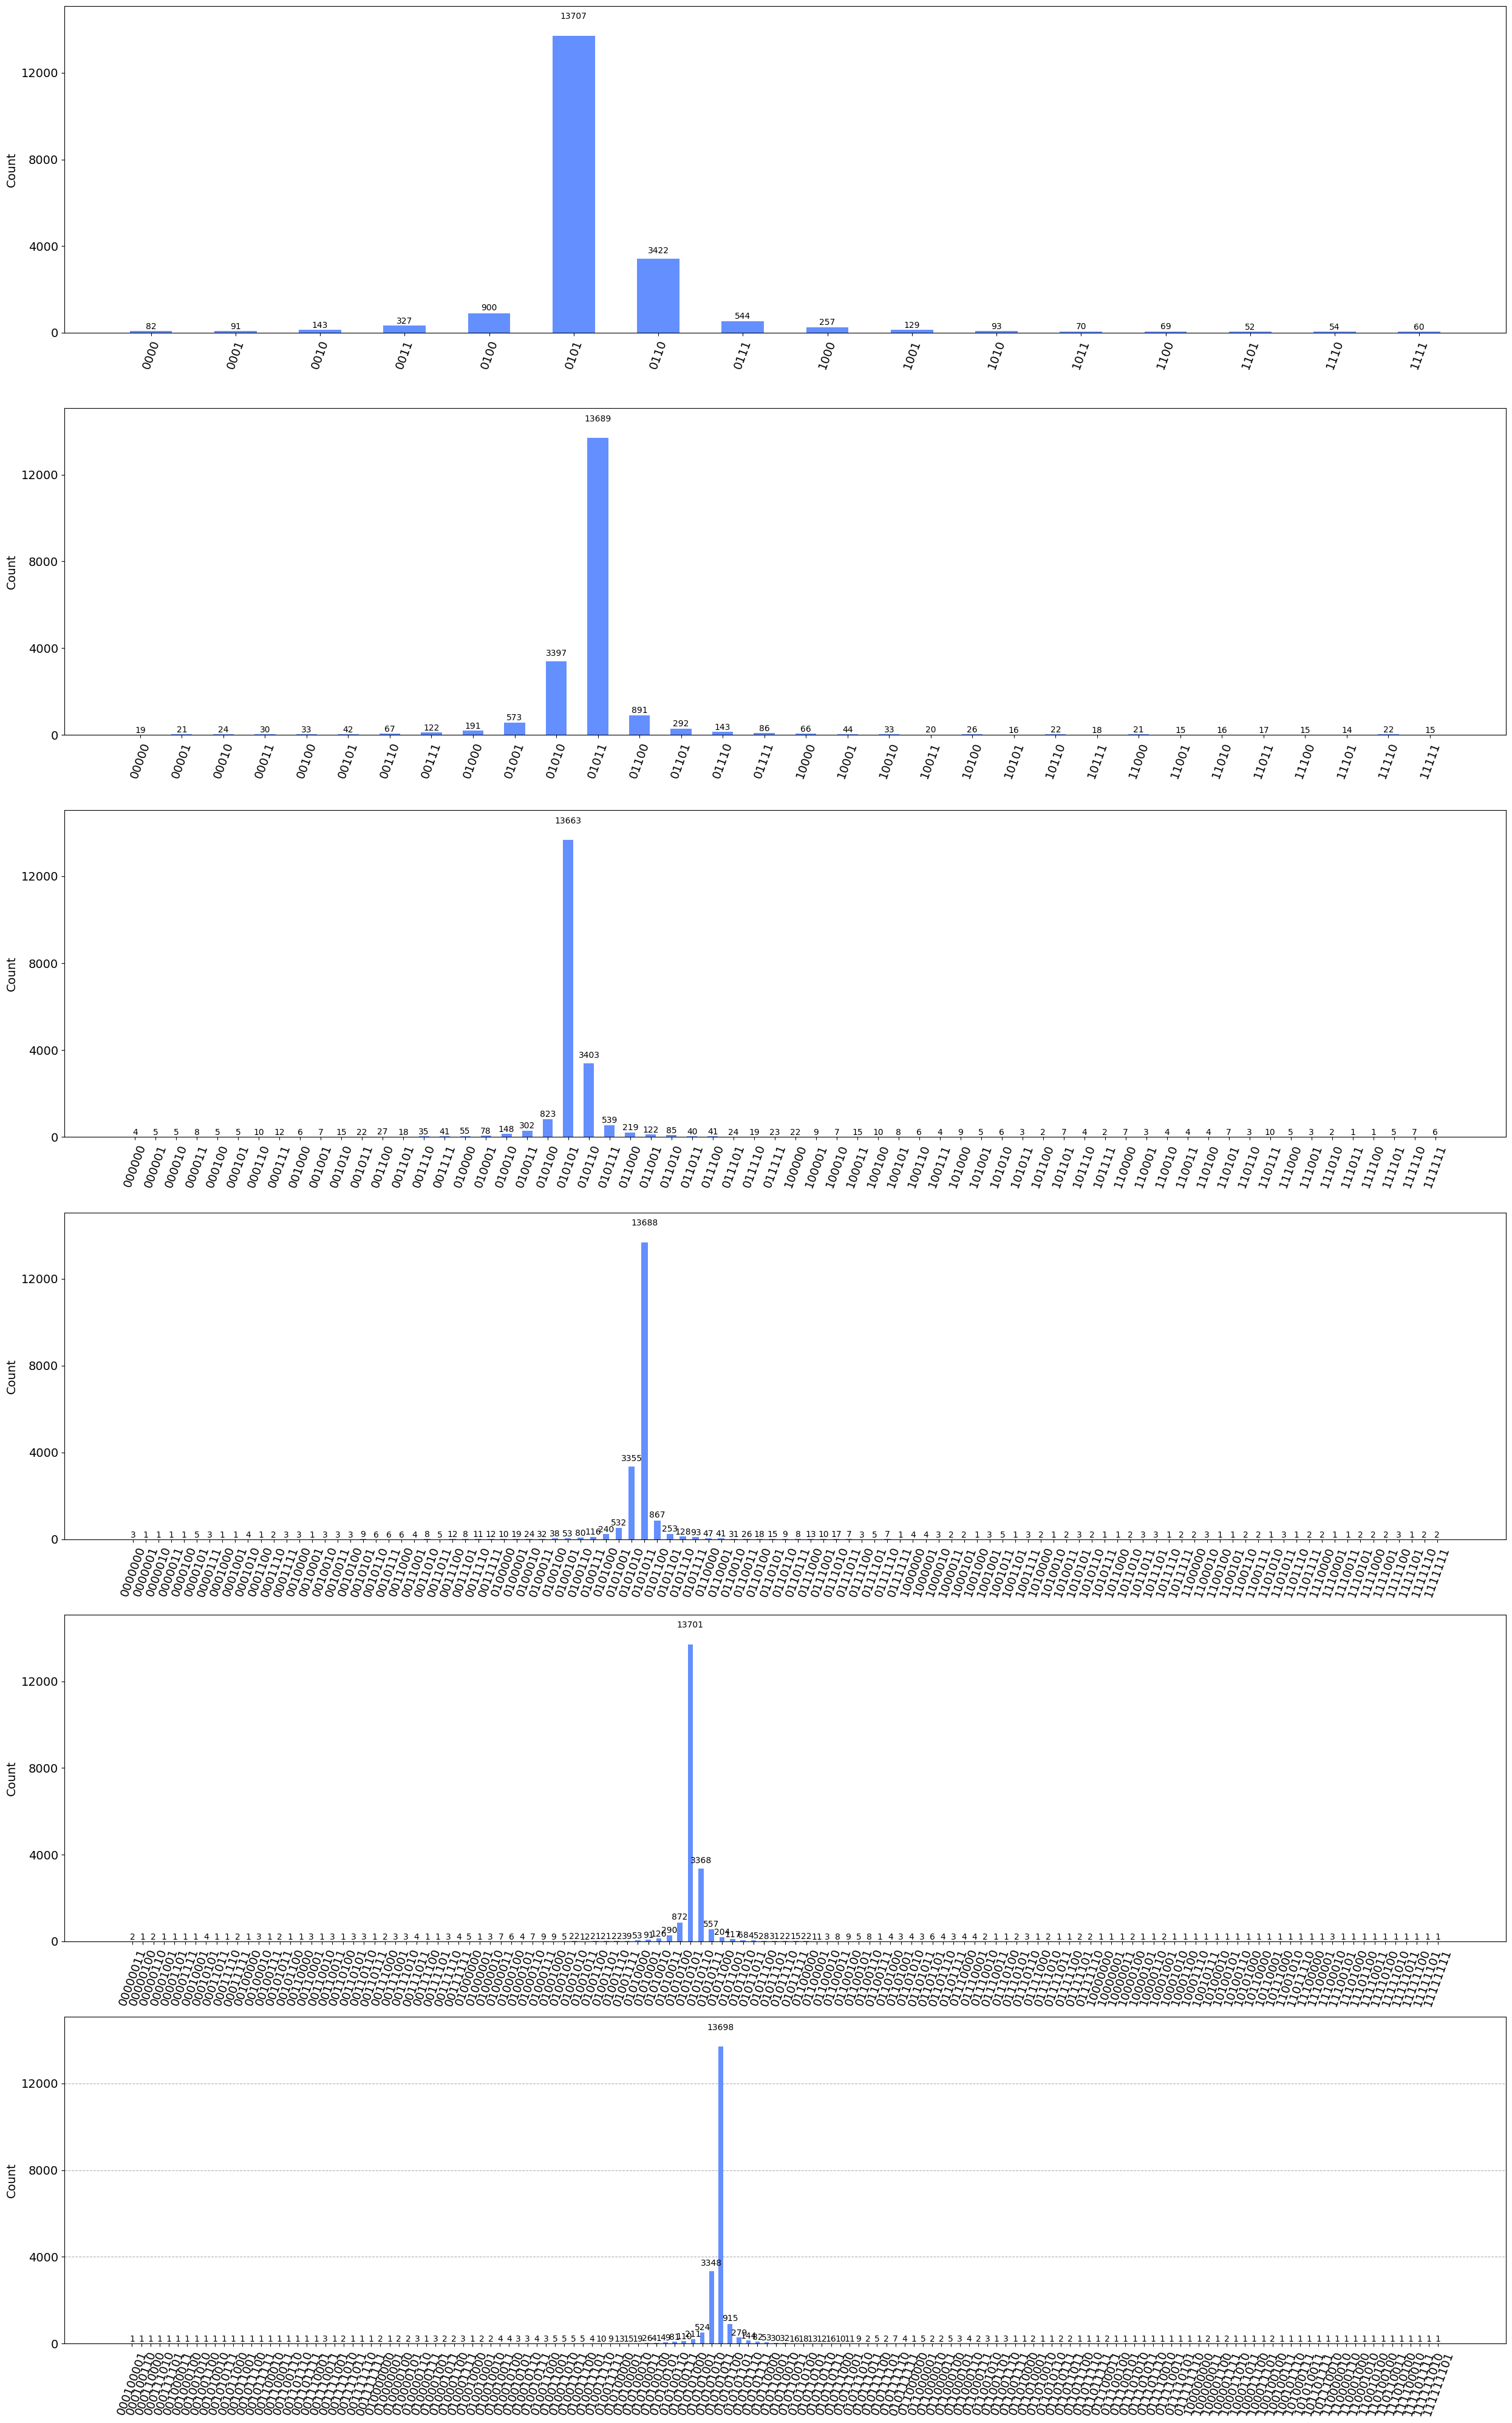

In [34]:
# Run this cell to simulate `circ` and plot the histograms of the results

results = execute(circ, sim, shots=shots).result()
n_circ = len(circ)

counts = [results.get_counts(idx) for idx in range(n_circ)]
fig, ax = plt.subplots(n_circ,1,figsize=(25,40))
for idx in range(n_circ):
    plot_histogram(counts[idx], ax=ax[idx])
plt.tight_layout()

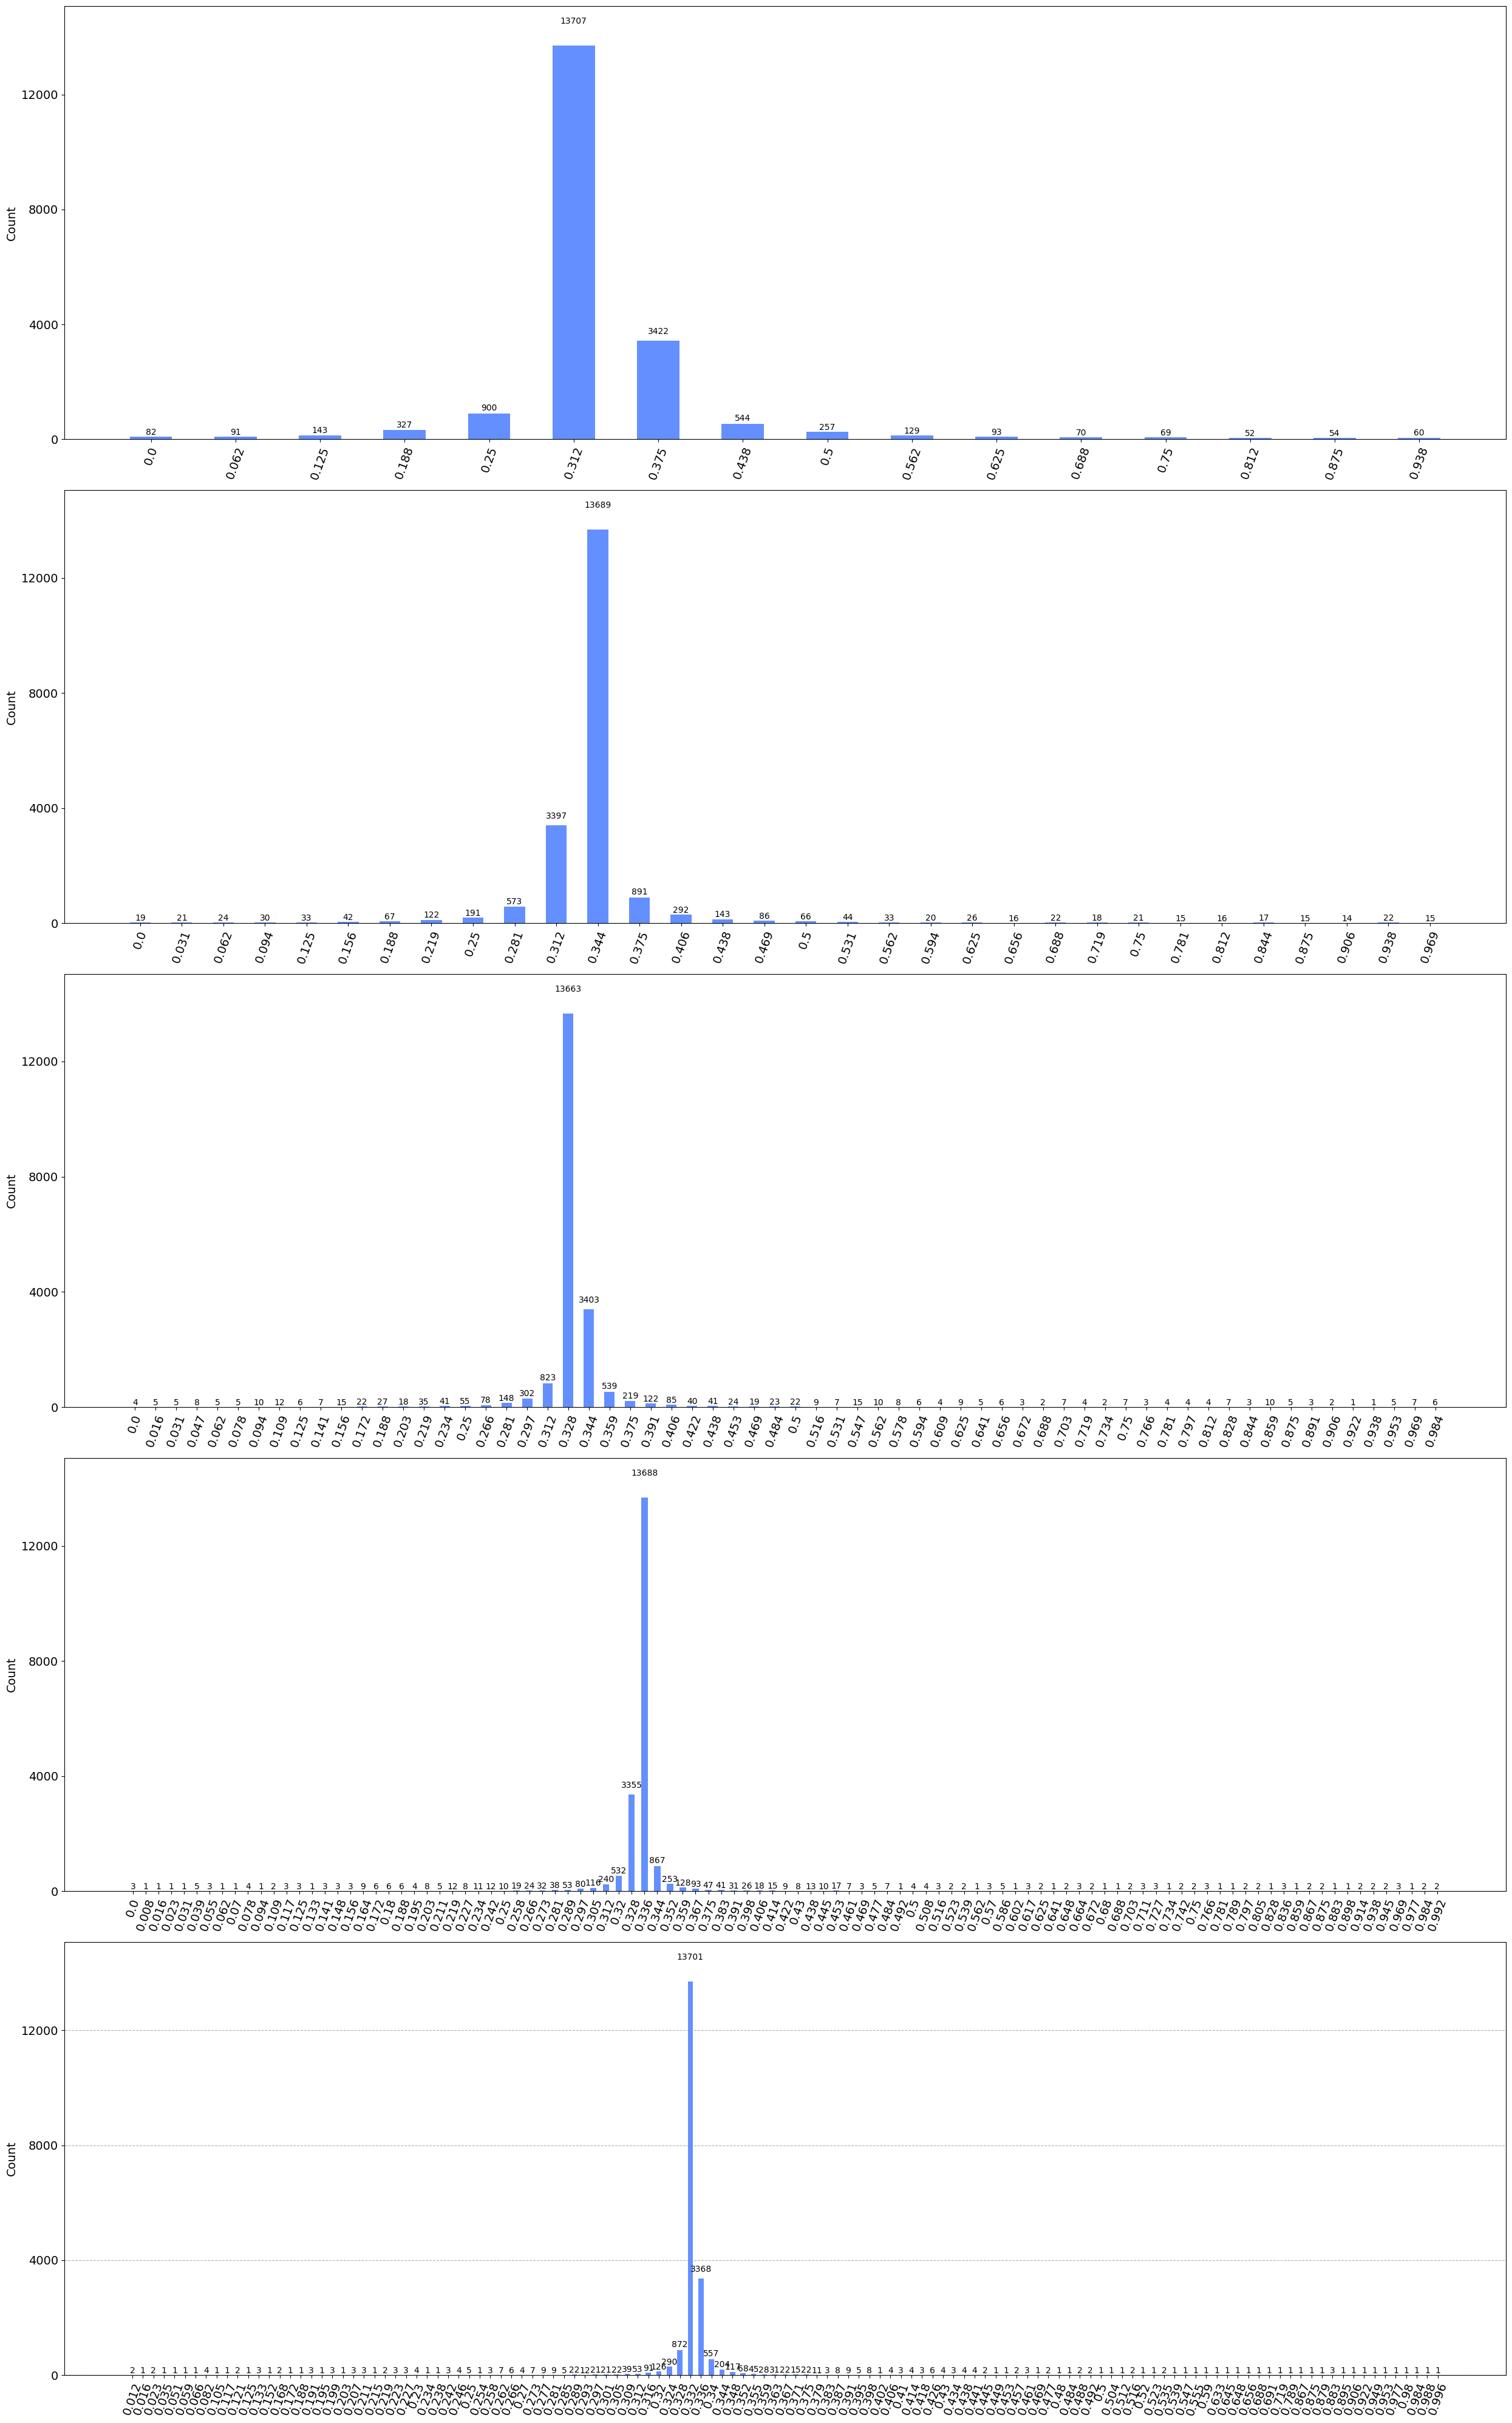

In [35]:
a=np.array([4,5,6,7,8,9])

counts_new=[]
for i in range(len(counts)):
    phi_est = np.array([round(int(key, 2)/2**a[i],3) for key in list(counts[i].keys())])
    key_new = list(map(str, phi_est))
    counts_new.append(dict(zip(key_new, counts[i].values())))


fig,ax=plt.subplots(5,1,figsize=(25,40))
for idx in range(5):
    plot_histogram(counts_new[idx], ax=ax[idx])
plt.tight_layout()

#### &#128211;Step B. Determine $e$, the maximum difference in integer from the best estimation for the different numer of counting qubits, $t = [4, 5, 6, 7, 8, 9]$. Verify the relationship $e=2^{t-n}-1$ where $n=2$ since the desired accuracy is $2^{-2}$ in this case. 

['0.312', '0.344', '0.328', '0.336', '0.332', '0.334']


Text(0, 0.5, 'e')

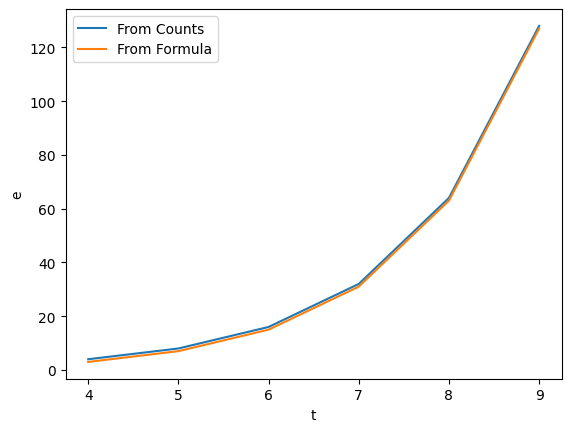

In [43]:
b_list=[]
for i in range(len(a)):
    m= max(zip(counts_new[i].values(), counts_new[i].keys()))[1]
    b_list.append(m)
print(b_list)
t=2
def e(t,b):
    Int_b=2**t*b
    m=0.312
    d=0.25
    Upper=2**t*(b+d)
    difference=Upper-Int_b
    return(difference)

e_list=[]
e2_list=[]
for i in range(len(a)):
    e_list.append(e(a[i],float(b_list[i])))
    e2_list.append(2**(a[i]-2)-1)

plt.plot(a,e_list,label="From Counts")
plt.plot(a,e2_list,label="From Formula")
plt.legend()
plt.xlabel("t")
plt.ylabel("e")









If you successfully calculated $e$ values for all the counting qubits, $t=[4,5,6,7,8,9]$, you will be able to generate the following graph that verifies the relationship $e = 2^{t-2} -1$ with the $e$ values that you computed.

![](images/L5_e_max.png)

#### &#128211;Step C. Evaluate the probability of success estimating $\phi$ to an accuracy $2^{-2}$ for all the values of $t$, the number of counting qubits. Save the probabilities to the list variable, 'prob_success'.  

In [68]:
## Your code to create the list variable, 'prob_success',  goes here


## finding accuracy needed in terms of phi
def prob(t,b,i):
    d=0.25
    Upper=2**t*(b+d)
    Upper_phi=Upper/(2**t)
    Lower_phi=b-(Upper_phi-b)
    good_outputs=0
    for key in counts_new[i]:
        if float(key) < Upper_phi and float(key) > Lower_phi:
            good_outputs+= counts_new[i][key]
    good_p=good_outputs/20000
    return(good_p)



print(prob(a[1],float(b_list[1]),1))


prob_success=[]
for i in range(len(a)):
    s=prob(a[i],float(b_list[i]),i)
    prob_success.append(s)
print(prob_success)

    






0.98495
[0.96955, 0.98495, 0.99265, 0.9958, 0.9983, 0.99905]


#### &#128211;Step D. Overlay the results of Step C on the graph that shows the relationship between the number of counting qubits, $t$, and the minimum probability of success to approximate the phase to an accuracy $2^{-2}$. Understand the result.  

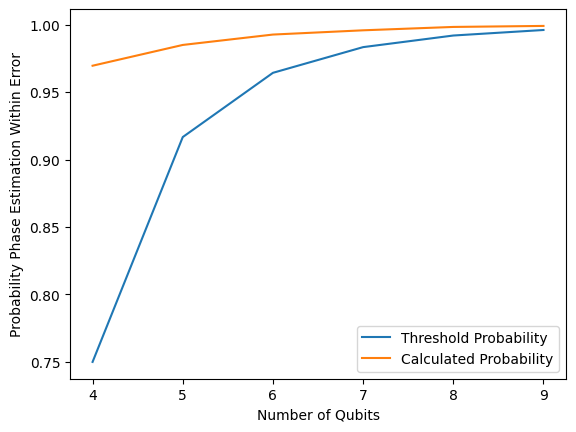

In [74]:
pg_list=[]
for i in range(len(a)):
    p=1-1/(2*(2**(a[i]-n)-2))
    pg_list.append(p)
plt.plot(a,pg_list,label="Threshold Probability")

plt.plot(a,prob_success,label="Calculated Probability")
plt.xlabel("Number of Qubits")
plt.ylabel("Probability Phase Estimation Within Error")
plt.legend()

















![](images/L5_prob_t.png)

Your plot should be similar to the above one. 
The line plot in the left pannel shows the minimum success probability to estimate $\phi$ within the accuracy $2^{-2}$ as the number of counting qubits varies. The overlayed orange dots are the same values, but from the simulation, which confirms the relationship the line plot represents as the lower bound.  The right pannel displays the same result but zoomed by adjusting the y-axis range.

The following graph exhibits the relationships with different accuracy levels.  The relationship, $t=n+log(2+\frac{1}{2\epsilon})$, indicates the number of counting qubits $t$ to estimate $\phi$ to an accuracy $2^{-2}$ with probability of success at least $1-\epsilon$, as we validated above. 

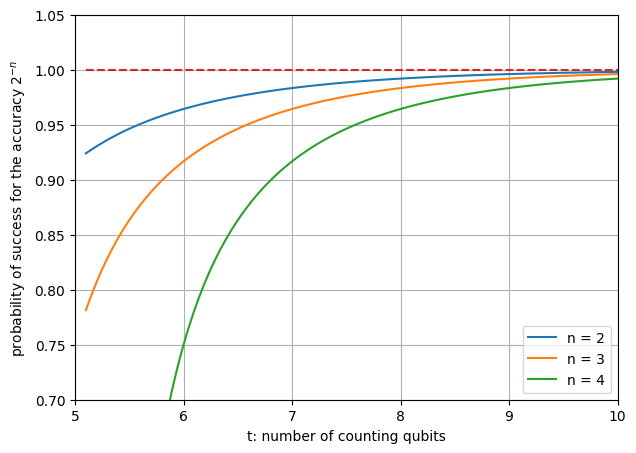

In [71]:
t = np.linspace(5.1, 10, 100)
prob_success_n = [y(t, n) for n in [2, 3, 4]]
prob_n2, prob_n3, prob_n4  = prob_success_n[0], prob_success_n[1], prob_success_n[2]

plt.figure(figsize=(7, 5))
plt.plot(t, prob_n2, t, prob_n3, t, prob_n4, t, [1]*len(t),'--' )
plt.axis([5, 10, 0.7, 1.05])
plt.xlabel('t: number of counting qubits')
plt.ylabel('probability of success for the accuracy $2^{-n}$')
plt.legend(['n = 2', 'n = 3', 'n = 4'], loc='lower right')
plt.grid(True)

## Part 2: QPE on Noisy Quantum System


**Goal**

Run the QPE circuit on a real quantum system to understand the result and limitations when using noisy quantum systems


The accuracy anaylsis that we performed in Part 1 would not be correct when the QPE circuit is executed on present day noisy quantum systems.  In part 2, we will obtain QPE results by running the circuit on a backend from IBM Quantum Experience to examine how noise affects the outcome and learn techniques to reduce its impact.   

#### &#128211;Step A. Load your account and select the backend from your provider. 

In [164]:
## Your code goes here.  
from qiskit.providers.fake_provider import FakeLondon
backend = FakeLondon()





#### &#128211;Step B. Generate multiple ( as many as you want ) transpiled circuits of <code>qc4</code> that you set up in Part 1 at the beginning. Choose one with the minimum circuit depth, and the other with the maximum circuit depth.

Transpile the circuit with the parameter `optimization_level = 3` to reduce the error in the result.  As we learned in Lab 1, Qiskit by default uses a stochastic swap mapper to place the needed SWAP gates, which varies the tranpiled circuit results even under the same runtime settings.  Therefore, to achieve shorter depth transpiled circuit for smaller error in the outcome, transpile `qc4` multiple times and choose one with the minimum circuit depth. Select the maximum circuit depth one as well for comparison purposes. 

In [165]:
## Your code goes here

one=transpile(qpe2,backend, optimization_level=1)
two=transpile(qpe2,backend, optimization_level=2)
three=transpile(qpe2,backend, optimization_level=3)





#### &#128211;Step C. Execute both circuits on the backend that you picked. Plot the histogram for the results and compare them with the simulation result in Part 1.

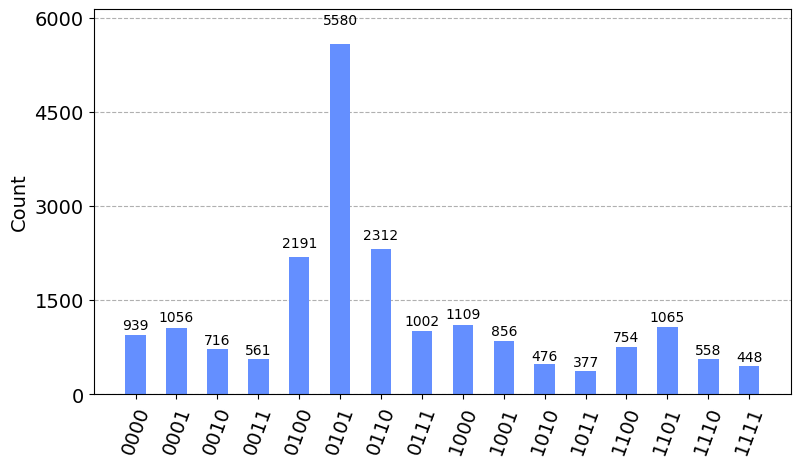

In [166]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
shots = 20000
job=backend.run(one,shots=shots)
count_qc4=job.result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

# shots = 20000
count_qc4 = execute(min, backend, shots=shots).result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

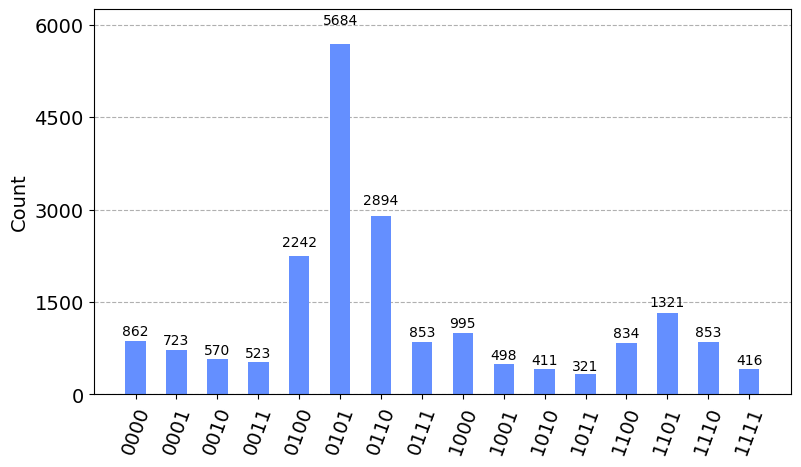

In [167]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
shots = 20000
job=backend.run(two,shots=shots)
count_qc4=job.result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

The following shows the sample result.

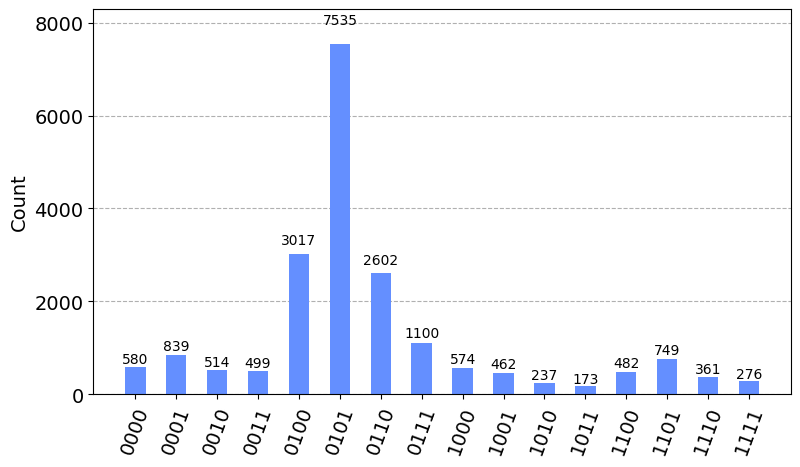

In [168]:
## Run this cell to simulate 'qc4' and to plot the histogram of the result
shots = 20000
job=backend.run(three,shots=shots)
count_qc4=job.result().get_counts()
plot_histogram(count_qc4, figsize=(9,5))

![](images/L5_QPEresults.png)

#### Step D. Measurement Error Mitigation 

In the previous step, we utilized our knowledge about Qiskit transpiler to get the best result. Here, we try to mitigate the errors in the result further through the measurement mitigation technique that we learned in Lab 3.

&#128211;Construct the circuits to profile the measurement errors of all basis states using the function 'complete_meas_cal'.  Obtain the measurement filter object, 'meas_filter', which will be applied to the noisy results to mitigate readout (measurement) error.

In [ ]:
##  Your Code goes here














&#128211;Plot the histogram of the results before and after the measurement error mitigation to exhibit the improvement.

In [ ]:
## Your Code goes here















The following plot shows the sample result. 

![](images/L5_QPEresults_final.png)

The figure below displays a simulation result with the sample final results from both the best and worst SWAP mapping cases after applying the measurement error mitigation.  In Lab 3, as the major source of the error was from the measurement, after the error mitigation procedure, the outcomes were significantly improved.  For QPE case, however, the measurement error doesn't seem to be the foremost cause for the noise in the result; CNOT gate errors dominate the noise profile. In this case, choosing the transpiled circuit with the least depth was the crucial procedure to reduce the errors in the result.

![](images/L5_QPE_final.png)